In [1]:
%run ../input/python-recipes/radial_gradient_header.py
%radial_gradient_header Code Modules & Helpful Tools|24

In [2]:
import os,h5py,tarfile,math,PIL
import numpy as np,pandas as pd
import tensorflow as tf,pylab as pl
from tensorflow.keras import layers as tkl
from tensorflow.keras import callbacks as tkc
from tensorflow.keras.preprocessing.image import \
load_img,array_to_img,img_to_array
from tensorflow.keras.preprocessing import \
image_dataset_from_directory
from mpl_toolkits.axes_grid1.inset_locator import \
zoomed_inset_axes,mark_inset
data_url='https://raw.githubusercontent.com/'+\
         'OlgaBelitskaya/data_kitchen/main/'
file_path='../input/object-detection/resolution/'
tar_file='resolution.tgz'

In [3]:
%radial_gradient_header Data Files|24

In [4]:
folder_names=['train','valid','test']
file_names=[[],[],[]]
for root,dirs,files in os.walk(file_path,topdown=True):
    for f in files:
        if '.jpg' in os.path.join(root,f):
            for i in range(3):
                if folder_names[i] in os.path.join(root,f): 
                    file_name=os.path.join(root,f)\
                    .replace(file_path,'')
                    file_names[i].append(file_name)
    for d in dirs:
        print(os.path.join(root,d),'\n',20*'<=>')
df=pd.DataFrame(file_names,index=folder_names).T
df.head()

../input/object-detection/resolution/data 
 <=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
../input/object-detection/resolution/data/images 
 <=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
../input/object-detection/resolution/data/images/valid 
 <=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
../input/object-detection/resolution/data/images/test 
 <=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
../input/object-detection/resolution/data/images/train 
 <=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>


train                       valid  \
0  data/images/train/0106.jpg  data/images/valid/0006.jpg   
1  data/images/train/0074.jpg  data/images/valid/0044.jpg   
2  data/images/train/0077.jpg  data/images/valid/0011.jpg   
3  data/images/train/0058.jpg  data/images/valid/0019.jpg   
4  data/images/train/0128.jpg  data/images/valid/0008.jpg   

                        test  
0  data/images/test/0006.jpg  
1  data/images/test/0044.jpg  
2  data/images/test/0011.jpg  
3  data/images/test/0019.jpg  
4  data/images/test/0008.jpg

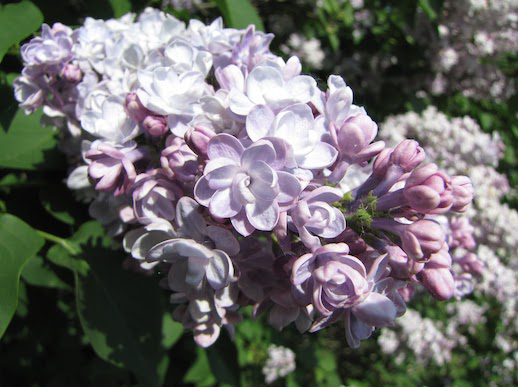

In [5]:
PIL.Image.open(file_path+df['valid'][7])

In [6]:
%radial_gradient_header Tar Archives|24 

In [7]:
with tarfile.open(tar_file,'w:gz') as tar:
    for root,dirs,files in os.walk(file_path):
        for f in files:
            file_name=os.path.join(root,f).replace(file_path,'')
            tar.add(os.path.join(root,f),file_name)
    tar.close()

In [8]:
file_names=[[],[],[]]
with tarfile.open(tar_file,'r:gz') as tar:
    files=tar.getnames()
    tar.close()
for i in range(3):
    for f in files:
        if folder_names[i] in f:
            file_names[i].append(f)
df=pd.DataFrame(file_names,index=folder_names).T
df.tail() 

train valid  test
175  data/images/train/0115.jpg  None  None
176  data/images/train/0086.jpg  None  None
177  data/images/train/0170.jpg  None  None
178  data/images/train/0001.jpg  None  None
179  data/images/train/0176.jpg  None  None

In [9]:
%radial_gradient_header TF Data from Tar Files|24

In [10]:
def scale01(img): return img/255
def process_input(input_rgb,img_size):
    input_yuv=tf.image.rgb_to_yuv(input_rgb)
    last_dimension_axis=len(input_yuv.shape)-1
    y,u,v=tf.split(input_yuv,3,axis=last_dimension_axis)
    return tf.image.resize(y,[img_size,img_size],method='area')
def process_target(input_rgb):
    input_yuv=tf.image.rgb_to_yuv(input_rgb)
    last_dimension_axis=len(input_yuv.shape)-1
    y,u,v=tf.split(input_yuv,3,axis=last_dimension_axis)
    return y

In [11]:
data_dir=tf.keras.utils.get_file(
    origin=data_url+tar_file,fname='resolution',
    extract=True,cache_dir='./')[:-11]
root_dir=os.path.join(data_dir,'data')
data_path=os.path.join(root_dir,'images')
test_path=os.path.join(data_path,'test')
test_paths=sorted(
    [os.path.join(test_path,fname) 
     for fname in os.listdir(test_path)
     if fname.endswith('.jpg')])
test_paths[:3]

24633344/24626244 [==============================] - 0s 0us/step


['./datasets/data/images/test/0001.jpg',
 './datasets/data/images/test/0002.jpg',
 './datasets/data/images/test/0003.jpg']

Found 270 files belonging to 1 classes.
Using 216 files for training.
Found 270 files belonging to 1 classes.
Using 54 files for validation.


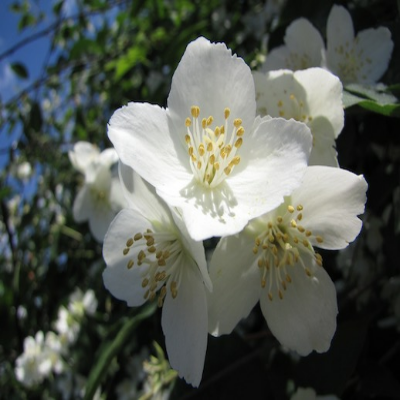

In [12]:
[crop_size,upscale_factor]=[400,4]
input_size=crop_size//upscale_factor
batch_size=8
train_ds=image_dataset_from_directory(
    root_dir,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='training',
    seed=12,label_mode=None,)
valid_ds=image_dataset_from_directory(
    root_dir,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='validation',
    seed=123,label_mode=None,)
train_ds=train_ds.map(scale01)
valid_ds=valid_ds.map(scale01)
for batch in train_ds.take(1):
    for img in batch: display(array_to_img(img)); break

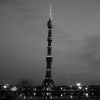

==> ==> ==> ==> ==> ==> ==> ==> ==> ==> 


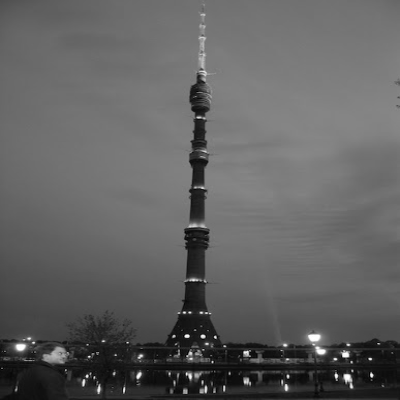

In [13]:
train_ds=train_ds.map(
    lambda x: (process_input(x,input_size),process_target(x)))
train_ds=train_ds.prefetch(buffer_size=16)
valid_ds=valid_ds.map(
    lambda x: (process_input(x,input_size),process_target(x)))
valid_ds=valid_ds.prefetch(buffer_size=16)
for batch in valid_ds.take(1):
    for img in batch[0]: display(array_to_img(img)); break
    print(10*'==> ')
    for img in batch[1]: display(array_to_img(img)); break

In [14]:
%radial_gradient_header Usage in Super-Resolution|24

In [15]:
def model(upscale_factor=upscale_factor,channels=1):
    conv_args={'activation':'relu',
               'kernel_initializer':'Orthogonal',
               'padding':'same',}
    inputs=tf.keras.Input(shape=(None,None,channels))
    x=tkl.Conv2D(512,5,**conv_args)(inputs)
    x=tkl.Conv2D(96,5,**conv_args)(x)
    x=tkl.Conv2D(32,3,**conv_args)(x)
    x=tkl.Conv2D(channels*(upscale_factor**2),3,**conv_args)(x)
    outputs=tf.nn.depth_to_space(x,upscale_factor)
    return tf.keras.Model(inputs,outputs)

In [16]:
def display_results(img,prefix,title):
    img_array=img_to_array(img)
    img_array=img_array.astype('float32')/255
    fig,ax=pl.subplots()
    im=ax.imshow(img_array[::-1],origin='lower')
    pl.title(title)
    axins=zoomed_inset_axes(ax,2,loc=5)
    axins.imshow(img_array[::-1],origin='lower')
    x1,x2,y1,y2=200,300,100,200
    axins.set_xlim(x1,x2); axins.set_ylim(y1,y2)
    pl.yticks(visible=False); pl.xticks(visible=False)
    mark_inset(ax,axins,loc1=2,loc2=3,fc='none',ec='magenta')
    pl.savefig(str(prefix)+'-'+title+'.png')
    pl.show()
def low_resolution_img(img,upscale_factor):
    dimensions=(img.size[0]//upscale_factor,
                img.size[1]//upscale_factor)
    return img.resize(dimensions,PIL.Image.BICUBIC,)
def upscale_img(model,img):
    ycbcr=img.convert('YCbCr')
    y,cb,cr=ycbcr.split()
    y=img_to_array(y).astype('float32')/255
    input_img=np.expand_dims(y,axis=0)
    out=model.predict(input_img)
    out_img_y=out[0]*255.
    out_img_y=out_img_y.clip(0,255)
    out_img_y=out_img_y.reshape(
        (np.shape(out_img_y)[0],np.shape(out_img_y)[1]))
    out_img_y=PIL.Image.fromarray(np.uint8(out_img_y),mode='L')
    out_img_cb=cb.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img_cr=cr.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img=PIL.Image.merge(
        'YCbCr',(out_img_y,out_img_cb,out_img_cr))
    return out_img.convert('RGB')

In [17]:
class ESPCNCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback,self).__init__()
        self.test_img=low_resolution_img(
            load_img(test_paths[0]),upscale_factor)
        self.mean_psnr=[]
    def on_epoch_begin(self,epoch,logs=None):
        self.psnr=[]
    def on_epoch_end(self,epoch,logs=None):
        print('mean PSNR for epoch: %.2f'%(np.mean(self.psnr)))
        if epoch%50==0:
            prediction=upscale_img(self.model,self.test_img)
            display_results(
                prediction,'epoch-'+str(epoch),'prediction')
        self.mean_psnr.append(np.mean(self.psnr))
    def on_test_batch_end(self,batch,logs=None):
        self.psnr.append(10*math.log10(1/logs['loss']))

In [18]:
early_stopping=tkc.EarlyStopping(
    monitor='loss',verbose=2,patience=20)
checkpoint_path='/tmp/checkpoint'
checkpoint=tkc.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    monitor='loss',mode='min',save_best_only=True,verbose=2)
lr_reduction=tkc.ReduceLROnPlateau(
    monitor='val_loss',patience=10,verbose=2,factor=.95)

In [19]:
model=model(upscale_factor=upscale_factor,channels=1)
callbacks=[ESPCNCallback(),early_stopping,checkpoint,lr_reduction]
loss_fn=tf.keras.losses.MeanSquaredError()
optimizer=tf.keras.optimizers.Adam(learning_rate=.001)

Epoch 1/1000
27/27 - 6s - loss: 0.0796 - val_loss: 0.0136
mean PSNR for epoch: 18.66


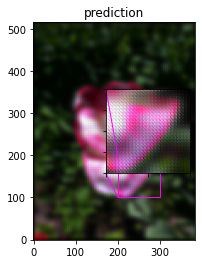


Epoch 00001: loss improved from inf to 0.07960, saving model to /tmp/checkpoint
Epoch 2/1000
27/27 - 2s - loss: 0.0114 - val_loss: 0.0083
mean PSNR for epoch: 20.83

Epoch 00002: loss improved from 0.07960 to 0.01139, saving model to /tmp/checkpoint
Epoch 3/1000
27/27 - 2s - loss: 0.0078 - val_loss: 0.0069
mean PSNR for epoch: 21.88

Epoch 00003: loss improved from 0.01139 to 0.00779, saving model to /tmp/checkpoint
Epoch 4/1000
27/27 - 2s - loss: 0.0067 - val_loss: 0.0059
mean PSNR for epoch: 22.05

Epoch 00004: loss improved from 0.00779 to 0.00666, saving model to /tmp/checkpoint
Epoch 5/1000
27/27 - 2s - loss: 0.0058 - val_loss: 0.0050
mean PSNR for epoch: 22.91

Epoch 00005: loss improved from 0.00666 to 0.00581, saving model to /tmp/checkpoint
Epoch 6/1000
27/27 - 2s - loss: 0.0048 - val_loss: 0.0042
mean PSNR for epoch: 23.85

Epoch 00006: loss improved from 0.00581 to 0.00478, saving model to /tmp/checkpoint
Epoch 7/1000
27/27 - 2s - loss: 0.0041 - val_loss: 0.0037
mean PSNR f

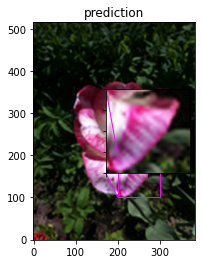


Epoch 00051: loss improved from 0.00291 to 0.00291, saving model to /tmp/checkpoint
Epoch 52/1000
27/27 - 2s - loss: 0.0029 - val_loss: 0.0028
mean PSNR for epoch: 25.51

Epoch 00052: loss improved from 0.00291 to 0.00291, saving model to /tmp/checkpoint
Epoch 53/1000
27/27 - 2s - loss: 0.0029 - val_loss: 0.0028
mean PSNR for epoch: 25.55

Epoch 00053: loss did not improve from 0.00291
Epoch 54/1000
27/27 - 2s - loss: 0.0029 - val_loss: 0.0028
mean PSNR for epoch: 25.97

Epoch 00054: loss did not improve from 0.00291
Epoch 55/1000
27/27 - 2s - loss: 0.0029 - val_loss: 0.0028
mean PSNR for epoch: 24.95

Epoch 00055: loss did not improve from 0.00291
Epoch 56/1000
27/27 - 2s - loss: 0.0030 - val_loss: 0.0029
mean PSNR for epoch: 25.28

Epoch 00056: loss did not improve from 0.00291
Epoch 57/1000
27/27 - 2s - loss: 0.0030 - val_loss: 0.0028
mean PSNR for epoch: 25.02

Epoch 00057: loss did not improve from 0.00291
Epoch 58/1000
27/27 - 2s - loss: 0.0029 - val_loss: 0.0028
mean PSNR for e

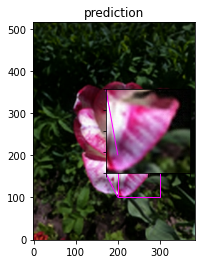


Epoch 00101: loss did not improve from 0.00282
Epoch 102/1000
27/27 - 2s - loss: 0.0028 - val_loss: 0.0028
mean PSNR for epoch: 25.52

Epoch 00102: loss did not improve from 0.00282
Epoch 103/1000
27/27 - 3s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.36

Epoch 00103: loss improved from 0.00282 to 0.00281, saving model to /tmp/checkpoint
Epoch 104/1000
27/27 - 2s - loss: 0.0028 - val_loss: 0.0028
mean PSNR for epoch: 25.37

Epoch 00104: loss did not improve from 0.00281
Epoch 105/1000
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 26.04

Epoch 00105: loss did not improve from 0.00281
Epoch 106/1000
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.43

Epoch 00106: loss improved from 0.00281 to 0.00281, saving model to /tmp/checkpoint
Epoch 107/1000
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.50

Epoch 00107: loss did not improve from 0.00281
Epoch 108/1000
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSN

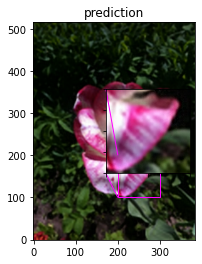


Epoch 00151: loss improved from 0.00276 to 0.00276, saving model to /tmp/checkpoint
Epoch 152/1000
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.85

Epoch 00152: loss improved from 0.00276 to 0.00276, saving model to /tmp/checkpoint
Epoch 153/1000
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.94

Epoch 00153: loss did not improve from 0.00276
Epoch 154/1000
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.91

Epoch 00154: loss improved from 0.00276 to 0.00276, saving model to /tmp/checkpoint
Epoch 155/1000
27/27 - 3s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.69

Epoch 00155: loss improved from 0.00276 to 0.00276, saving model to /tmp/checkpoint

Epoch 00155: ReduceLROnPlateau reducing learning rate to 0.0005403600225690752.
Epoch 156/1000
27/27 - 3s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.26

Epoch 00156: loss improved from 0.00276 to 0.00276, saving model to /tmp/checkpoint
Epoch 157/1

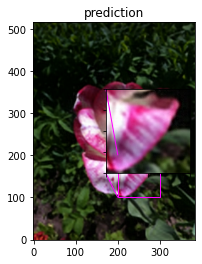


Epoch 00201: loss improved from 0.00274 to 0.00274, saving model to /tmp/checkpoint
Epoch 202/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 26.06

Epoch 00202: loss improved from 0.00274 to 0.00273, saving model to /tmp/checkpoint
Epoch 203/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 25.58

Epoch 00203: loss improved from 0.00273 to 0.00273, saving model to /tmp/checkpoint
Epoch 204/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 26.62

Epoch 00204: loss improved from 0.00273 to 0.00273, saving model to /tmp/checkpoint
Epoch 205/1000
27/27 - 3s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 25.98

Epoch 00205: loss did not improve from 0.00273

Epoch 00205: ReduceLROnPlateau reducing learning rate to 0.00041812024719547477.
Epoch 206/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 25.49

Epoch 00206: loss did not improve from 0.00273
Epoch 207/1000
27/27 - 2s - loss: 0.0027 - val_

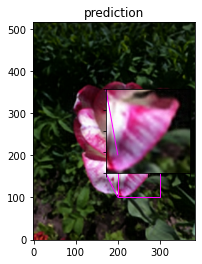


Epoch 00251: loss improved from 0.00270 to 0.00270, saving model to /tmp/checkpoint
Epoch 252/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 25.65

Epoch 00252: loss improved from 0.00270 to 0.00270, saving model to /tmp/checkpoint
Epoch 253/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 25.68

Epoch 00253: loss did not improve from 0.00270
Epoch 254/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0026
mean PSNR for epoch: 26.35

Epoch 00254: loss did not improve from 0.00270
Epoch 255/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0026
mean PSNR for epoch: 26.01

Epoch 00255: loss did not improve from 0.00270

Epoch 00255: ReduceLROnPlateau reducing learning rate to 0.00032353347924072293.
Epoch 256/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0026
mean PSNR for epoch: 25.57

Epoch 00256: loss did not improve from 0.00270
Epoch 257/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0026
mean PSNR for epoch: 25.62

Epoch 00257: loss improved from 0

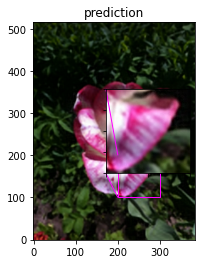


Epoch 00301: loss did not improve from 0.00267
Epoch 302/1000
27/27 - 3s - loss: 0.0027 - val_loss: 0.0026
mean PSNR for epoch: 26.54

Epoch 00302: loss improved from 0.00267 to 0.00267, saving model to /tmp/checkpoint
Epoch 303/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0026
mean PSNR for epoch: 25.94

Epoch 00303: loss did not improve from 0.00267
Epoch 304/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0026
mean PSNR for epoch: 25.43

Epoch 00304: loss did not improve from 0.00267
Epoch 305/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0026
mean PSNR for epoch: 25.78

Epoch 00305: loss improved from 0.00267 to 0.00267, saving model to /tmp/checkpoint
Epoch 306/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0026
mean PSNR for epoch: 25.92

Epoch 00306: loss improved from 0.00267 to 0.00267, saving model to /tmp/checkpoint
Epoch 307/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0026
mean PSNR for epoch: 25.39

Epoch 00307: loss improved from 0.00267 to 0.00267, saving model to /tmp/check

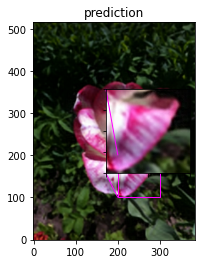


Epoch 00351: loss improved from 0.00265 to 0.00265, saving model to /tmp/checkpoint
Epoch 352/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0026
mean PSNR for epoch: 26.03

Epoch 00352: loss did not improve from 0.00265
Epoch 353/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0026
mean PSNR for epoch: 26.26

Epoch 00353: loss did not improve from 0.00265
Epoch 354/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0026
mean PSNR for epoch: 26.45

Epoch 00354: loss did not improve from 0.00265
Epoch 355/1000
27/27 - 3s - loss: 0.0027 - val_loss: 0.0026
mean PSNR for epoch: 25.70

Epoch 00355: loss did not improve from 0.00265
Epoch 356/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0026
mean PSNR for epoch: 25.66

Epoch 00356: loss did not improve from 0.00265
Epoch 357/1000
27/27 - 2s - loss: 0.0027 - val_loss: 0.0026
mean PSNR for epoch: 25.68

Epoch 00357: loss did not improve from 0.00265

Epoch 00357: ReduceLROnPlateau reducing learning rate to 0.00019371145172044634.
Epoch 358/1000
27/27 - 

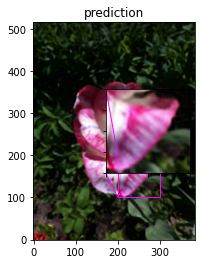


Epoch 00401: loss improved from 0.00263 to 0.00263, saving model to /tmp/checkpoint
Epoch 402/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 25.97

Epoch 00402: loss did not improve from 0.00263
Epoch 403/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 26.05

Epoch 00403: loss improved from 0.00263 to 0.00263, saving model to /tmp/checkpoint
Epoch 404/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 25.73

Epoch 00404: loss did not improve from 0.00263
Epoch 405/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 25.57

Epoch 00405: loss did not improve from 0.00263
Epoch 406/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 25.95

Epoch 00406: loss did not improve from 0.00263
Epoch 407/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 25.66

Epoch 00407: loss did not improve from 0.00263

Epoch 00407: ReduceLROnPlateau reducing learning rate to 0.00014989

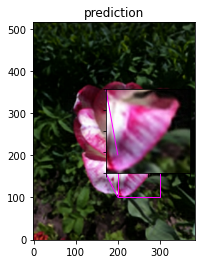


Epoch 00451: loss did not improve from 0.00261
Epoch 452/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 25.93

Epoch 00452: loss improved from 0.00261 to 0.00261, saving model to /tmp/checkpoint
Epoch 453/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 26.85

Epoch 00453: loss did not improve from 0.00261
Epoch 454/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 25.98

Epoch 00454: loss did not improve from 0.00261
Epoch 455/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 25.90

Epoch 00455: loss did not improve from 0.00261
Epoch 456/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 26.04

Epoch 00456: loss did not improve from 0.00261
Epoch 457/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 26.12

Epoch 00457: loss improved from 0.00261 to 0.00261, saving model to /tmp/checkpoint

Epoch 00457: ReduceLROnPlateau reducing learning rate to 0.00011598

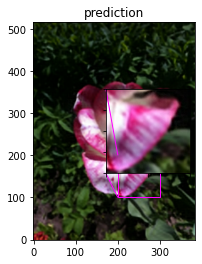


Epoch 00501: loss improved from 0.00260 to 0.00260, saving model to /tmp/checkpoint
Epoch 502/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 25.83

Epoch 00502: loss did not improve from 0.00260
Epoch 503/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 26.07

Epoch 00503: loss did not improve from 0.00260
Epoch 504/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 25.50

Epoch 00504: loss did not improve from 0.00260
Epoch 505/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 26.29

Epoch 00505: loss did not improve from 0.00260
Epoch 506/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 26.20

Epoch 00506: loss did not improve from 0.00260
Epoch 507/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 26.51

Epoch 00507: loss did not improve from 0.00260

Epoch 00507: ReduceLROnPlateau reducing learning rate to 8.974481388577259e-05.
Epoch 508/1000
27/27 - 2

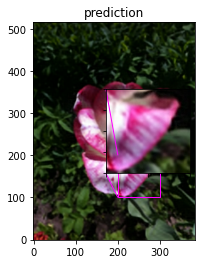


Epoch 00551: loss improved from 0.00259 to 0.00259, saving model to /tmp/checkpoint
Epoch 552/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 25.92

Epoch 00552: loss did not improve from 0.00259
Epoch 553/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 25.67

Epoch 00553: loss improved from 0.00259 to 0.00259, saving model to /tmp/checkpoint
Epoch 554/1000
27/27 - 3s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 26.03

Epoch 00554: loss improved from 0.00259 to 0.00259, saving model to /tmp/checkpoint
Epoch 555/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 25.81

Epoch 00555: loss improved from 0.00259 to 0.00259, saving model to /tmp/checkpoint
Epoch 556/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 25.93

Epoch 00556: loss did not improve from 0.00259
Epoch 557/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 25.87

Epoch 00557: loss did not improve from 0.

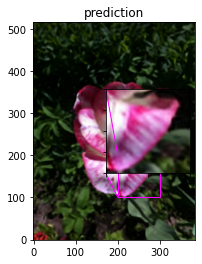


Epoch 00601: loss improved from 0.00258 to 0.00258, saving model to /tmp/checkpoint
Epoch 602/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.91

Epoch 00602: loss did not improve from 0.00258
Epoch 603/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.51

Epoch 00603: loss improved from 0.00258 to 0.00258, saving model to /tmp/checkpoint
Epoch 604/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 26.07

Epoch 00604: loss improved from 0.00258 to 0.00258, saving model to /tmp/checkpoint
Epoch 605/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 26.12

Epoch 00605: loss did not improve from 0.00258
Epoch 606/1000
27/27 - 3s - loss: 0.0026 - val_loss: 0.0026
mean PSNR for epoch: 25.24

Epoch 00606: loss did not improve from 0.00258
Epoch 607/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.77

Epoch 00607: loss did not improve from 0.00258

Epoch 00607: ReduceLROnPlateau

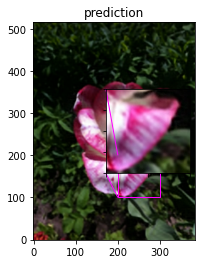


Epoch 00651: loss did not improve from 0.00257
Epoch 652/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.98

Epoch 00652: loss did not improve from 0.00257
Epoch 653/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.46

Epoch 00653: loss improved from 0.00257 to 0.00257, saving model to /tmp/checkpoint
Epoch 654/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.59

Epoch 00654: loss improved from 0.00257 to 0.00257, saving model to /tmp/checkpoint
Epoch 655/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.41

Epoch 00655: loss did not improve from 0.00257
Epoch 656/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.97

Epoch 00656: loss improved from 0.00257 to 0.00257, saving model to /tmp/checkpoint
Epoch 657/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 26.17

Epoch 00657: loss did not improve from 0.00257

Epoch 00657: ReduceLROnPlateau

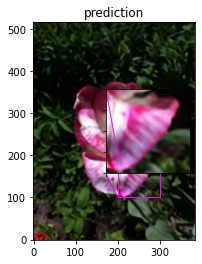


Epoch 00701: loss improved from 0.00256 to 0.00256, saving model to /tmp/checkpoint

Epoch 00701: ReduceLROnPlateau reducing learning rate to 3.3865528712340166e-05.
Epoch 702/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.76

Epoch 00702: loss did not improve from 0.00256
Epoch 703/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.97

Epoch 00703: loss improved from 0.00256 to 0.00256, saving model to /tmp/checkpoint
Epoch 704/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 26.09

Epoch 00704: loss did not improve from 0.00256
Epoch 705/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 26.44

Epoch 00705: loss improved from 0.00256 to 0.00256, saving model to /tmp/checkpoint
Epoch 706/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 26.03

Epoch 00706: loss did not improve from 0.00256
Epoch 707/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 26.

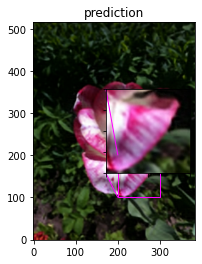


Epoch 00751: loss improved from 0.00256 to 0.00256, saving model to /tmp/checkpoint

Epoch 00751: ReduceLROnPlateau reducing learning rate to 2.620450213726144e-05.
Epoch 752/1000
27/27 - 3s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.65

Epoch 00752: loss improved from 0.00256 to 0.00256, saving model to /tmp/checkpoint
Epoch 753/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.83

Epoch 00753: loss improved from 0.00256 to 0.00256, saving model to /tmp/checkpoint
Epoch 754/1000
27/27 - 3s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 26.49

Epoch 00754: loss did not improve from 0.00256
Epoch 755/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 26.32

Epoch 00755: loss did not improve from 0.00256
Epoch 756/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 26.19

Epoch 00756: loss did not improve from 0.00256
Epoch 757/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 26.5

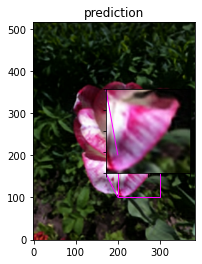


Epoch 00801: loss did not improve from 0.00255

Epoch 00801: ReduceLROnPlateau reducing learning rate to 2.0276544091757387e-05.
Epoch 802/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.91

Epoch 00802: loss did not improve from 0.00255
Epoch 803/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 26.15

Epoch 00803: loss improved from 0.00255 to 0.00255, saving model to /tmp/checkpoint
Epoch 804/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 26.39

Epoch 00804: loss did not improve from 0.00255
Epoch 805/1000
27/27 - 3s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.78

Epoch 00805: loss did not improve from 0.00255
Epoch 806/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.69

Epoch 00806: loss did not improve from 0.00255
Epoch 807/1000
27/27 - 3s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.80

Epoch 00807: loss improved from 0.00255 to 0.00255, saving model to /t

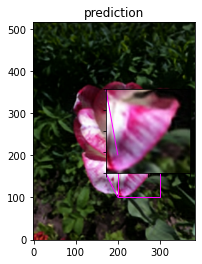


Epoch 00851: loss did not improve from 0.00255

Epoch 00851: ReduceLROnPlateau reducing learning rate to 1.568960378790507e-05.
Epoch 852/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.44

Epoch 00852: loss improved from 0.00255 to 0.00255, saving model to /tmp/checkpoint
Epoch 853/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.50

Epoch 00853: loss improved from 0.00255 to 0.00255, saving model to /tmp/checkpoint
Epoch 854/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.95

Epoch 00854: loss improved from 0.00255 to 0.00255, saving model to /tmp/checkpoint
Epoch 855/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.67

Epoch 00855: loss did not improve from 0.00255
Epoch 856/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.79

Epoch 00856: loss did not improve from 0.00255
Epoch 857/1000
27/27 - 2s - loss: 0.0026 - val_loss: 0.0025
mean PSNR for epoch: 25.8

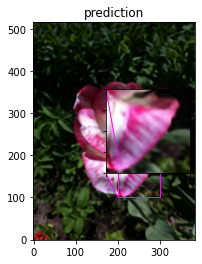


Epoch 00901: loss did not improve from 0.00255

Epoch 00901: ReduceLROnPlateau reducing learning rate to 1.2140316039221942e-05.
Epoch 902/1000
27/27 - 2s - loss: 0.0025 - val_loss: 0.0025
mean PSNR for epoch: 26.02

Epoch 00902: loss did not improve from 0.00255
Epoch 903/1000
27/27 - 2s - loss: 0.0025 - val_loss: 0.0025
mean PSNR for epoch: 26.20

Epoch 00903: loss did not improve from 0.00255
Epoch 904/1000
27/27 - 2s - loss: 0.0025 - val_loss: 0.0025
mean PSNR for epoch: 26.25

Epoch 00904: loss did not improve from 0.00255
Epoch 905/1000
27/27 - 2s - loss: 0.0025 - val_loss: 0.0025
mean PSNR for epoch: 25.55

Epoch 00905: loss did not improve from 0.00255
Epoch 906/1000
27/27 - 2s - loss: 0.0025 - val_loss: 0.0025
mean PSNR for epoch: 26.41

Epoch 00906: loss improved from 0.00255 to 0.00255, saving model to /tmp/checkpoint
Epoch 907/1000
27/27 - 2s - loss: 0.0025 - val_loss: 0.0025
mean PSNR for epoch: 25.96

Epoch 00907: loss did not improve from 0.00255
Epoch 908/1000
27/27 - 

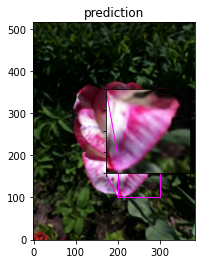


Epoch 00951: loss improved from 0.00255 to 0.00255, saving model to /tmp/checkpoint

Epoch 00951: ReduceLROnPlateau reducing learning rate to 9.393945629199151e-06.
Epoch 952/1000
27/27 - 2s - loss: 0.0025 - val_loss: 0.0025
mean PSNR for epoch: 26.16

Epoch 00952: loss improved from 0.00255 to 0.00255, saving model to /tmp/checkpoint
Epoch 953/1000
27/27 - 2s - loss: 0.0025 - val_loss: 0.0025
mean PSNR for epoch: 26.01

Epoch 00953: loss improved from 0.00255 to 0.00255, saving model to /tmp/checkpoint
Epoch 954/1000
27/27 - 2s - loss: 0.0025 - val_loss: 0.0025
mean PSNR for epoch: 26.07

Epoch 00954: loss did not improve from 0.00255
Epoch 955/1000
27/27 - 2s - loss: 0.0025 - val_loss: 0.0025
mean PSNR for epoch: 25.70

Epoch 00955: loss did not improve from 0.00255
Epoch 956/1000
27/27 - 2s - loss: 0.0025 - val_loss: 0.0025
mean PSNR for epoch: 26.11

Epoch 00956: loss improved from 0.00255 to 0.00255, saving model to /tmp/checkpoint
Epoch 957/1000
27/27 - 2s - loss: 0.0025 - val_l

In [20]:
epochs=1000
model.compile(optimizer=optimizer,loss=loss_fn,)
history=model.fit(
    train_ds,epochs=epochs,callbacks=callbacks,
    validation_data=valid_ds,verbose=2)
model.load_weights(checkpoint_path);

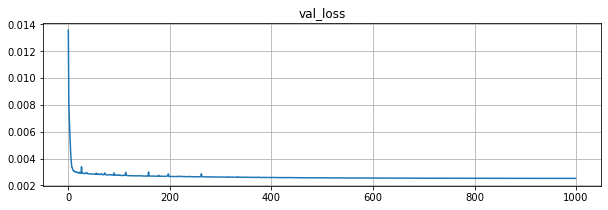

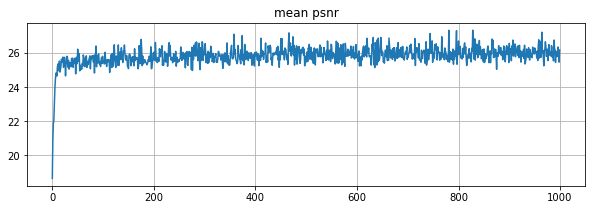

In [21]:
history_keys=list(history.history.keys())
pl.figure(figsize=(10,3))
pl.plot(history.history[history_keys[1]])
pl.grid(); pl.title(history_keys[1]); pl.show()
pl.figure(figsize=(10,3))
pl.plot(callbacks[0].mean_psnr)
pl.grid(); pl.title('mean psnr'); pl.show()

PSNR of low resolution and high resolution is 27.7133
PSNR of predict and high resolution is 28.4274


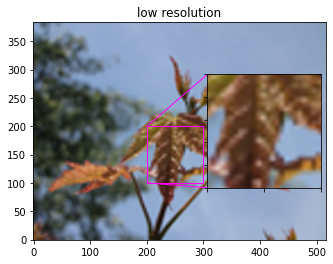

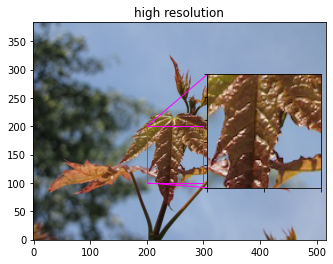

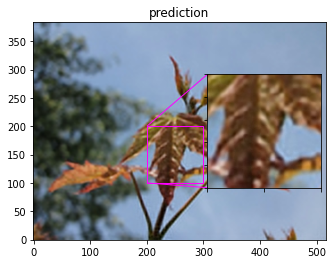

PSNR of low resolution and high resolution is 30.4634
PSNR of predict and high resolution is 31.9754


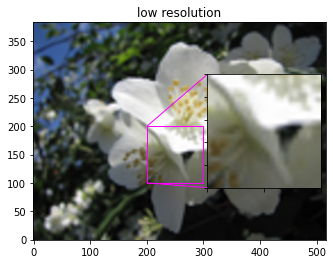

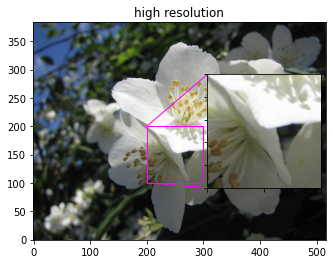

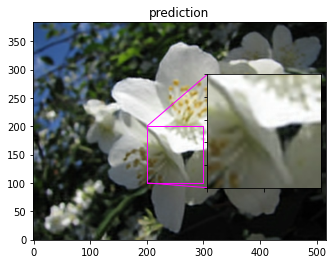

PSNR of low resolution and high resolution is 26.3540
PSNR of predict and high resolution is 27.4017


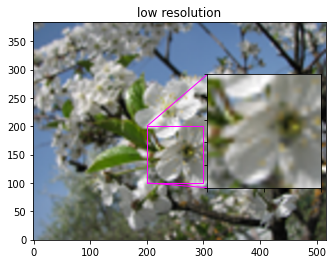

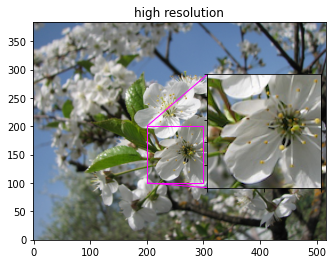

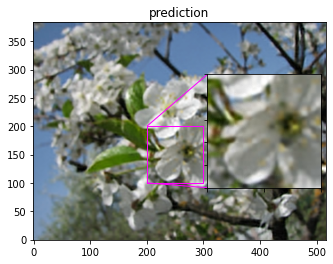

PSNR of low resolution and high resolution is 28.6121
PSNR of predict and high resolution is 29.7472


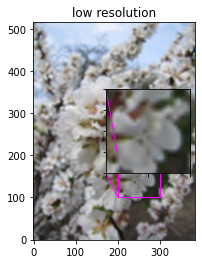

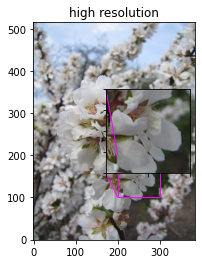

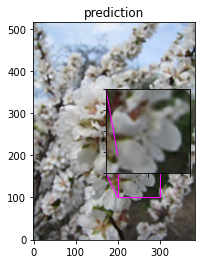

PSNR of low resolution and high resolution is 20.4599
PSNR of predict and high resolution is 20.8686


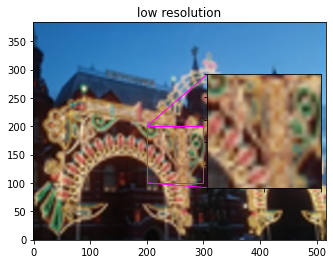

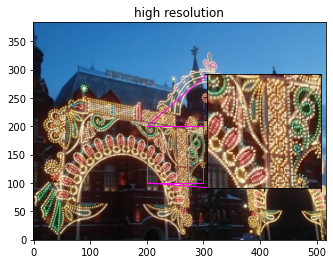

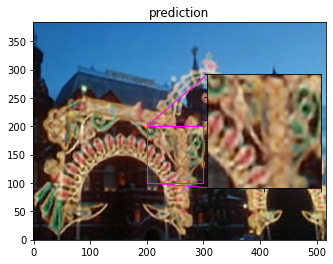

PSNR of low resolution and high resolution is 23.8670
PSNR of predict and high resolution is 24.5852


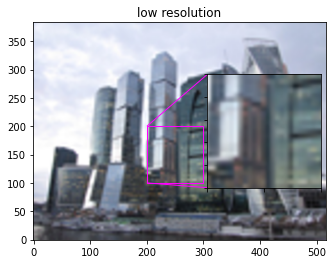

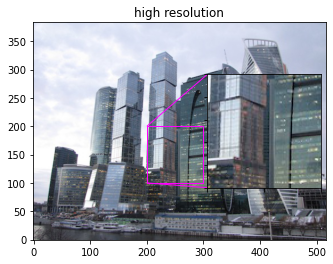

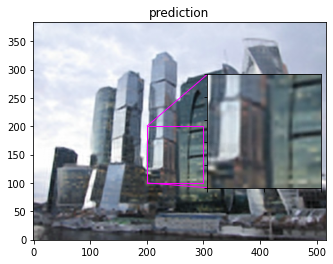

PSNR of low resolution and high resolution is 24.0932
PSNR of predict and high resolution is 25.4885


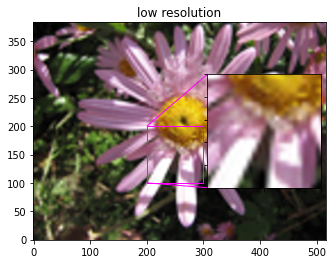

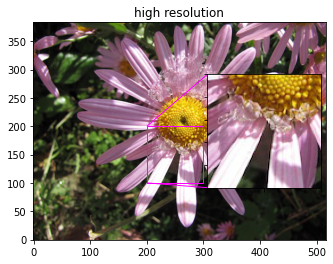

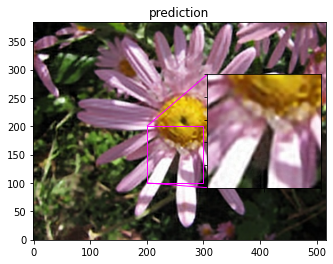

PSNR of low resolution and high resolution is 26.9738
PSNR of predict and high resolution is 27.9895


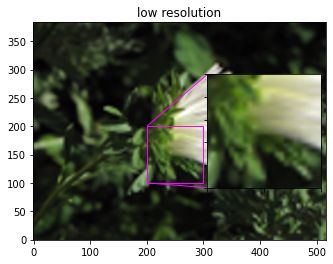

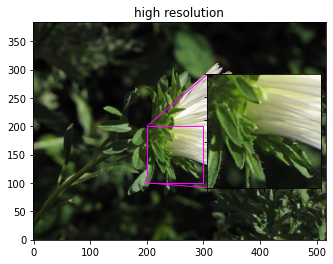

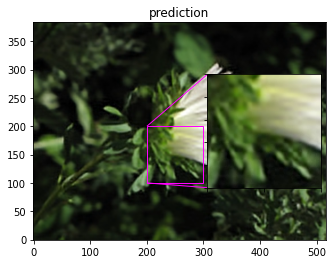

PSNR of low resolution and high resolution is 27.9112
PSNR of predict and high resolution is 28.6498


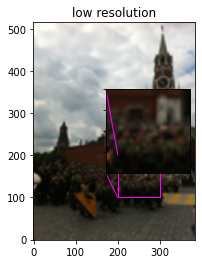

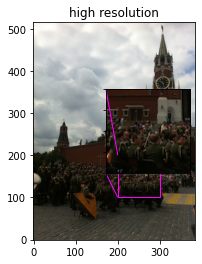

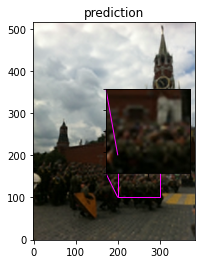

PSNR of low resolution and high resolution is 22.3869
PSNR of predict and high resolution is 23.2115


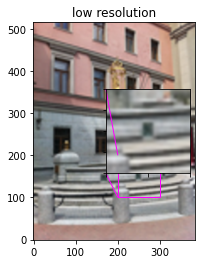

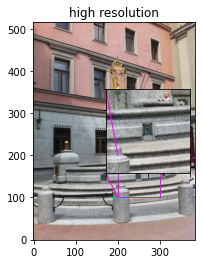

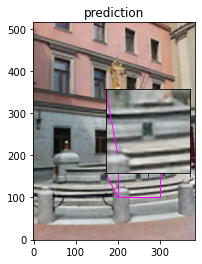

avg. PSNR of images with low resolution is 25.8835
avg. PSNR of reconstructions is 26.8345


In [22]:
total_bicubic_psnr=0.; total_test_psnr=0.; n_img=10
for index,test_path in enumerate(test_paths[5:5+n_img]):
    img=load_img(test_path)
    lowres_input=low_resolution_img(img,upscale_factor)
    w=lowres_input.size[0]*upscale_factor
    h=lowres_input.size[1]*upscale_factor
    highres_img=img.resize((w,h))
    predict_img=upscale_img(model,lowres_input)
    lowres_img=lowres_input.resize((w,h))
    lowres_img_arr=img_to_array(lowres_img)
    highres_img_arr=img_to_array(highres_img)
    predict_img_arr=img_to_array(predict_img)
    bicubic_psnr=tf.image.psnr(
        lowres_img_arr,highres_img_arr,max_val=255)
    test_psnr=tf.image.psnr(
        predict_img_arr,highres_img_arr,max_val=255)
    total_bicubic_psnr+=bicubic_psnr
    total_test_psnr+=test_psnr
    print('PSNR of low resolution '+\
          'and high resolution is %.4f'%bicubic_psnr)
    print('PSNR of predict and high resolution is %.4f'%test_psnr)
    display_results(lowres_img,index,'low resolution')
    display_results(highres_img,index,'high resolution')
    display_results(predict_img,index,'prediction')
print('avg. PSNR of images with low resolution is %.4f'\
      %(total_bicubic_psnr/n_img))
print('avg. PSNR of reconstructions is %.4f'\
      %(total_test_psnr/n_img))